# Machine Learning

## Homework 4 code

Daniel Castro 87644

João Tiago Aaprício 97155



In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np

import sklearn.decomposition
import matplotlib.pyplot as plt

### Dataset

In this part of the tutorial we will use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, which is widely used for introducing image classification problems: 

* 70k examples of handwritten digits
* Image size: 28x28
* 1 channel
* 10 classes: [0-9]

In [0]:
mnist_data, mnist_info = tfds.load('mnist', with_info=True)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.0. Subsequent calls will reuse this data.


In [0]:
print(mnist_info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [0]:
mnist_train_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['train'])])
mnist_train_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['train'])])

mnist_test_x = np.asarray([instance['image']/255 for instance in tfds.as_numpy(mnist_data['test'])])
mnist_test_y = np.asarray([instance['label'] for instance in tfds.as_numpy(mnist_data['test'])])

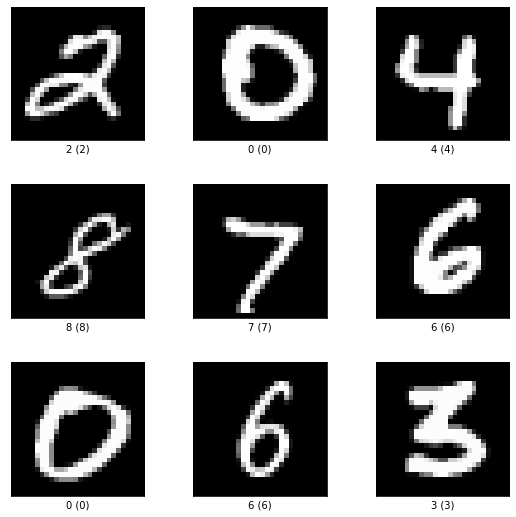

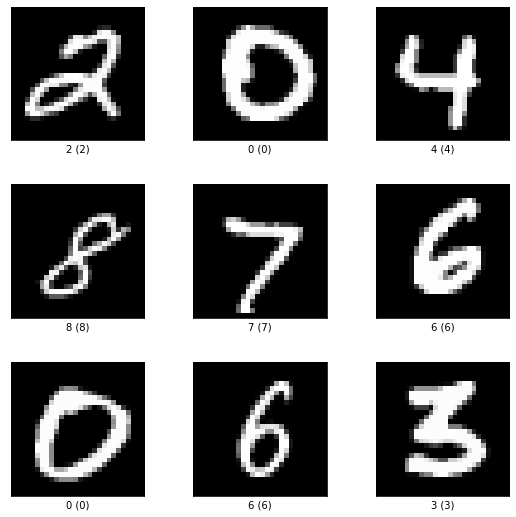

In [0]:
tfds.show_examples(mnist_info, mnist_data['test'])

## Convolutional Neural Networks

Convolutional layers capture patterns corresponding to relevant features independently of where they occur in the input. To do so, they slide a window over the input and apply the convolution operation with a set of kernels or filters that represent the features. Although it is not their only field of application, convolutional neural networks are mainly praised for their performance on image processing tasks. 

We can see that, in this case, the dataset has a standard partition of 60k examples for training and 10k for testing. Let's convert them to [NumPy](https://numpy.org/) arrays:

Furthermore, the dataset includes methods for visualizing examples:

### Models

Now, let's create and train some networks to approach the problem posed by the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

#### Baseline

As a baseline, let's use a feed-forward network to approach the problem. The only difference from the previous networks is that we need to [flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) the image before passing it to the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer:

In [0]:
mnist_baseline_model = tf.keras.Sequential(name='mnist_baseline')
mnist_baseline_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_baseline_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_baseline_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_baseline_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_baseline_model.summary()

Model: "mnist_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


Now we can train the model. We will still use part of the training set for validation, in order to control when to stop the training phase:

In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_baseline_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_baseline_model_train = mnist_baseline_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
184/188 [============================>.] - ETA: 0s - loss: 1.6609 - accuracy: 0.5821
Epoch 00001: val_accuracy improved from -inf to 0.76200, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 1.6529 - accuracy: 0.5853 - val_loss: 1.2292 - val_accuracy: 0.7620
Epoch 2/10000
173/188 [==========================>...] - ETA: 0s - loss: 1.0509 - accuracy: 0.7931
Epoch 00002: val_accuracy improved from 0.76200 to 0.81367, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 3ms/step - loss: 1.0405 - accuracy: 0.7946 - val_loss: 0.9082 - val_accuracy: 0.8137
Epoch 3/10000
188/188 [==============================] - ETA: 0s - loss: 0.8253 - accuracy: 0.8261
Epoch 00003: val_accuracy improved from 0.81367 to 0.83325, saving model to mnist_baseline_best.h5
188/188 [==============================] - 1s 3ms/step - loss: 0.8253 - accuracy: 0.8261 - val_loss: 0.7646 - val_accuracy: 0.8332
Epoch 4/10000
17

Let's see how the performance evolved on the training and validation data:

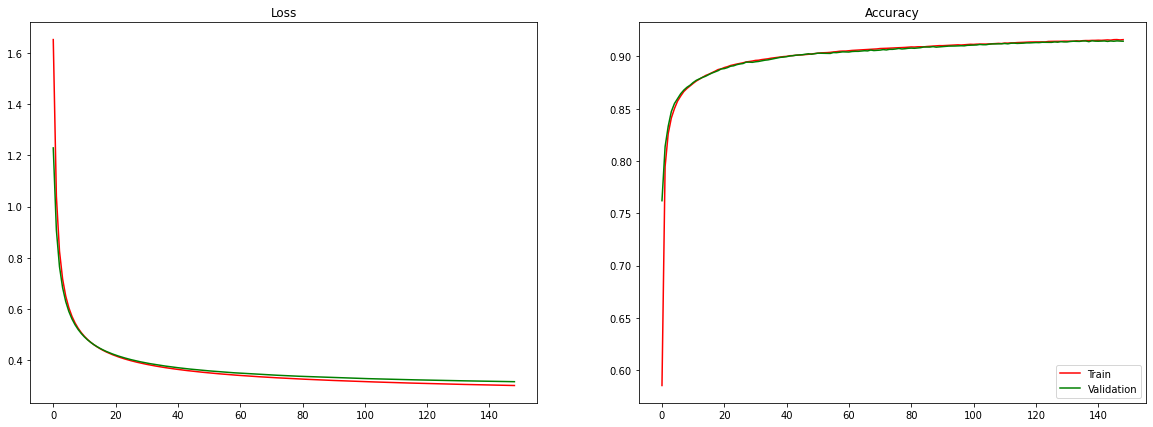

In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_baseline_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_baseline_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_baseline_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_baseline_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

Now let's load the best model for the validation data and evaluate it on the test set:

In [0]:
mnist_baseline_model.load_weights('mnist_baseline_best.h5')
loss, acc = mnist_baseline_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.2955 - accuracy: 0.9176
Accuracy: 0.9175999760627747


#### Convolutional Neural Network

To create our CNN, instead of feeding the flatenned output directly to the output layer, we will first pass it through a convolutional layer followed by a max pooling operation. Since, we are dealing with 2D data, we will use the [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers. 

In the convolutional layer, the *filters* parameter defines the number of kernels or filters used in the layer. The *kernel_size* parameter defines the size of the kernels. If only one number is provided, the kernel is assumed to be square. The stride values default to one, but can be changed using the *strides* parameter. Also, we can use same padding, by setting the *padding* parameter to 'same'.

For the pooling operation, we define the size of the pooling window using the *pool_size* parameter. Similarly to the *kernel_size* parameter of the convolutional layer, if only one number is provided, the window is assumed to be square. Additionally, the *strides* parameter defaults to the size of the pooling window. That is, there is no overlap.

In [0]:
mnist_conv_model = tf.keras.Sequential(name='mnist_cnn')
mnist_conv_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_conv_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
mnist_conv_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
mnist_conv_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_conv_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_conv_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_conv_model.summary()

Model: "mnist_cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        272       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
output (Dense)               (None, 10)                31370     
Total params: 31,642
Trainable params: 31,642
Non-trainable params: 0
_________________________________________________________________


Let's train the model using the same approach as before:

In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_conv_model_train = mnist_conv_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
187/188 [============================>.] - ETA: 0s - loss: 1.5485 - accuracy: 0.6357
Epoch 00001: val_accuracy improved from -inf to 0.82300, saving model to mnist_conv_best.h5
188/188 [==============================] - 1s 5ms/step - loss: 1.5462 - accuracy: 0.6363 - val_loss: 0.7717 - val_accuracy: 0.8230
Epoch 2/10000
178/188 [===========================>..] - ETA: 0s - loss: 0.5788 - accuracy: 0.8559
Epoch 00002: val_accuracy improved from 0.82300 to 0.87300, saving model to mnist_conv_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.5738 - accuracy: 0.8566 - val_loss: 0.4719 - val_accuracy: 0.8730
Epoch 3/10000
175/188 [==========================>...] - ETA: 0s - loss: 0.4309 - accuracy: 0.8810
Epoch 00003: val_accuracy improved from 0.87300 to 0.88958, saving model to mnist_conv_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.4291 - accuracy: 0.8812 - val_loss: 0.4014 - val_accuracy: 0.8896
Epoch 4/10000
178/188 [=====

And visualize the evolution:

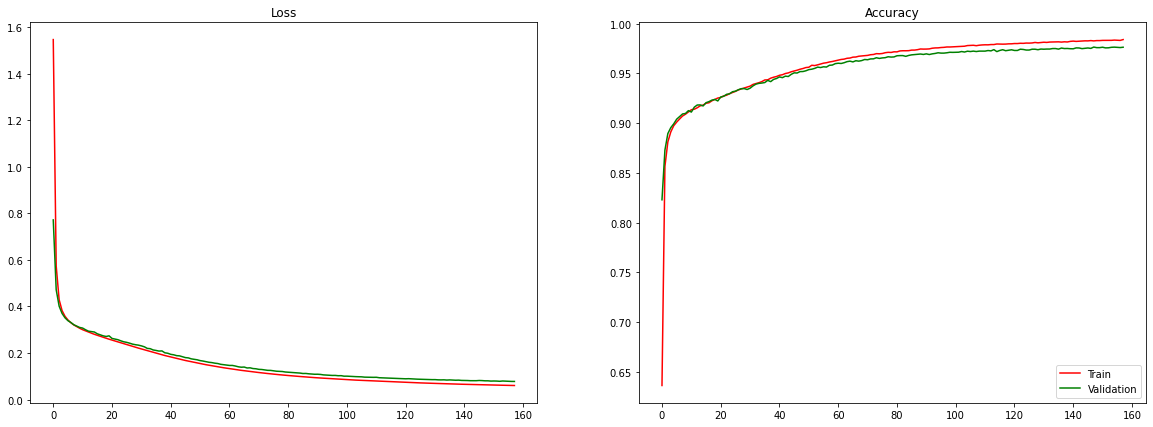

In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_conv_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_conv_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_conv_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_conv_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

Finally, we can evaluate the model on the test set, and verify that the performance is higher than without the convolutional layers.

In [0]:
mnist_conv_model.load_weights('mnist_conv_best.h5')
loss, acc = mnist_conv_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0681 - accuracy: 0.9794
Accuracy: 0.9793999791145325


#### Dropout

In this scenario, instead of applying regularization to the weights, we will use a different approach to regularization, namely, dropout. The idea behind dropout is to disable a percentage of randomly selected neurons during each step of the training phase, in order to avoid overfitting. In [Keras](https://www.tensorflow.org/api_docs/python/tf/keras), we can apply dropout directly to some layers by defining the corresponding parameters, or by using the [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer and stating the percentage of neurons to disable.

In [0]:
mnist_conv_drop_model = tf.keras.Sequential(name='mnist_cnn_dropout')
mnist_conv_drop_model.add(tf.keras.layers.Input(mnist_info.features['image'].shape))
mnist_conv_drop_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
mnist_conv_drop_model.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
mnist_conv_drop_model.add(tf.keras.layers.Dropout(0.5, name='dropout'))
mnist_conv_drop_model.add(tf.keras.layers.Flatten(name='flatten'))
mnist_conv_drop_model.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
mnist_conv_drop_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
mnist_conv_drop_model.summary()

Model: "mnist_cnn_dropout"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        272       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
output (Dense)               (None, 10)                31370     
Total params: 31,642
Trainable params: 31,642
Non-trainable params: 0
_________________________________________________________________


Let's train the model:

In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('mnist_conv_drop_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

mnist_conv_drop_model_train = mnist_conv_drop_model.fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
186/188 [============================>.] - ETA: 0s - loss: 1.8251 - accuracy: 0.4728
Epoch 00001: val_accuracy improved from -inf to 0.80808, saving model to mnist_conv_drop_best.h5
188/188 [==============================] - 1s 5ms/step - loss: 1.8191 - accuracy: 0.4747 - val_loss: 0.9870 - val_accuracy: 0.8081
Epoch 2/10000
174/188 [==========================>...] - ETA: 0s - loss: 0.7896 - accuracy: 0.7771
Epoch 00002: val_accuracy improved from 0.80808 to 0.85725, saving model to mnist_conv_drop_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.7791 - accuracy: 0.7787 - val_loss: 0.5237 - val_accuracy: 0.8572
Epoch 3/10000
174/188 [==========================>...] - ETA: 0s - loss: 0.5767 - accuracy: 0.8275
Epoch 00003: val_accuracy improved from 0.85725 to 0.88142, saving model to mnist_conv_drop_best.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.5739 - accuracy: 0.8281 - val_loss: 0.4302 - val_accuracy: 0.8814
Epoch 4/10000

By looking at the evolution, we can see that the performance of the model on the training data is now lower.

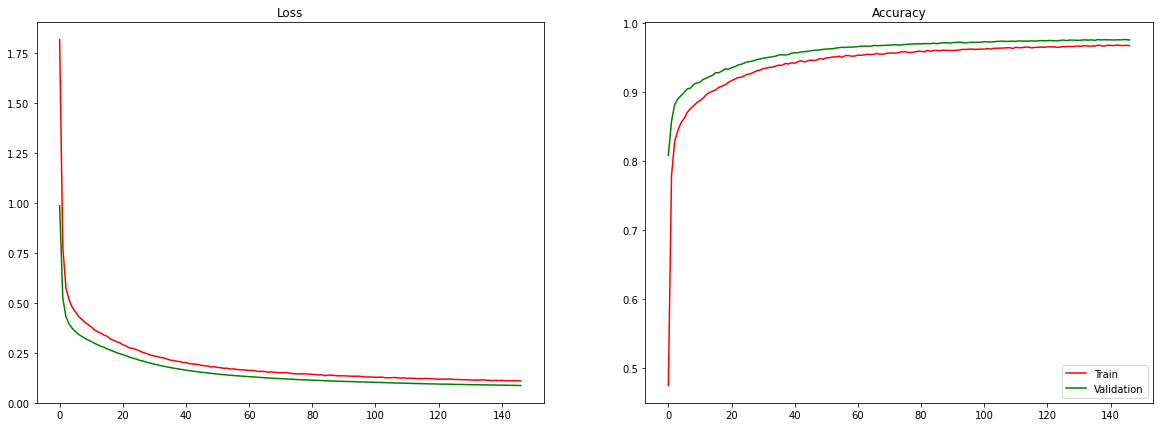

In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(mnist_conv_drop_model_train.history['loss'], '-r', label='Train')
loss_ax.plot(mnist_conv_drop_model_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(mnist_conv_drop_model_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(mnist_conv_drop_model_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

And we can assess the performance on the test set:

In [0]:
mnist_conv_drop_model.load_weights('mnist_conv_drop_best.h5')
loss, acc = mnist_conv_drop_model.evaluate(mnist_test_x, mnist_test_y)
print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0761 - accuracy: 0.9768
Accuracy: 0.9768000245094299


### Experiment no. 1, Number of Hidden Layers

+ 1, 2 or 3 Hidden Layers

#### Create NN

In [0]:
num = 3
model_exp_1 = [0] * num
for i in range(num):
  model_name = 'model_exp_1_' + str(i)
  model_exp_1[i] = tf.keras.Sequential(name=model_name)
  model_exp_1[i].add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  model_exp_1[i].add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution'))
  model_exp_1[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling'))
  model_exp_1[i].add(tf.keras.layers.Dropout(0.5, name='dropout'))
  model_exp_1[i].add(tf.keras.layers.Flatten(name='flatten'))

  model_exp_1[i].add(tf.keras.layers.Dense(32, activation='tanh', name='hidden1'))
  if(i==1):
    model_exp_1[i].add(tf.keras.layers.Dense(32, activation='tanh', name='hidden2'))
  if(i==2):
    model_exp_1[i].add(tf.keras.layers.Dense(32, activation='tanh', name='hidden3'))

  model_exp_1[i].add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  model_exp_1[i].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_exp_1[i].summary()

Model: "model_exp_1_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution (Conv2D)         (None, 28, 28, 16)        272       
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 32)                100384    
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 100,986
Trainable params: 100,986
Non-trainable params: 0
_______________________________________________

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
model_train_exp_1 = [0] * num
for i in range(num):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  model_checkpoint_name = 'model_exp_1_' + str(i) + '.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

  model_train_exp_1[i] = model_exp_1[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
176/188 [===========================>..] - ETA: 0s - loss: 0.5817 - accuracy: 0.8434
Epoch 00001: val_accuracy improved from -inf to 0.93508, saving model to model_exp_1_0.h5
188/188 [==============================] - 1s 5ms/step - loss: 0.5644 - accuracy: 0.8476 - val_loss: 0.2462 - val_accuracy: 0.9351
Epoch 2/10000
179/188 [===========================>..] - ETA: 0s - loss: 0.2331 - accuracy: 0.9345
Epoch 00002: val_accuracy improved from 0.93508 to 0.95875, saving model to model_exp_1_0.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.2314 - accuracy: 0.9350 - val_loss: 0.1521 - val_accuracy: 0.9588
Epoch 3/10000
177/188 [===========================>..] - ETA: 0s - loss: 0.1641 - accuracy: 0.9539
Epoch 00003: val_accuracy improved from 0.95875 to 0.96875, saving model to model_exp_1_0.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.1632 - accuracy: 0.9540 - val_loss: 0.1153 - val_accuracy: 0.9688
Epoch 4/10000
175/188 [===========

#### Plot the graphs of Loss and Accuracy

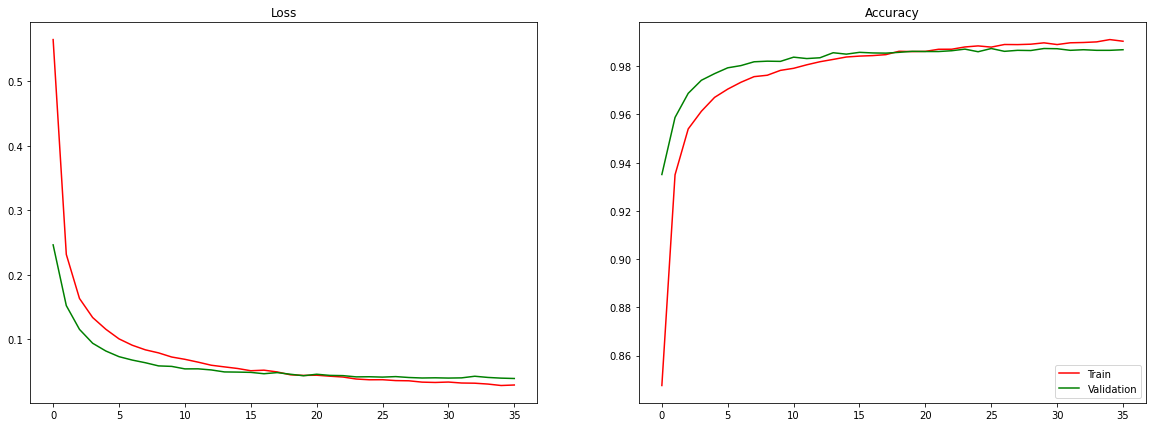

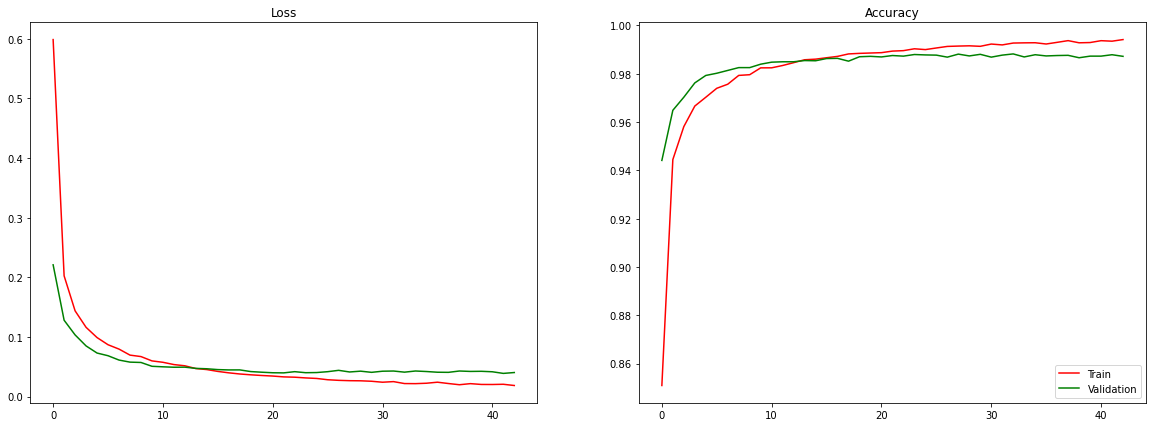

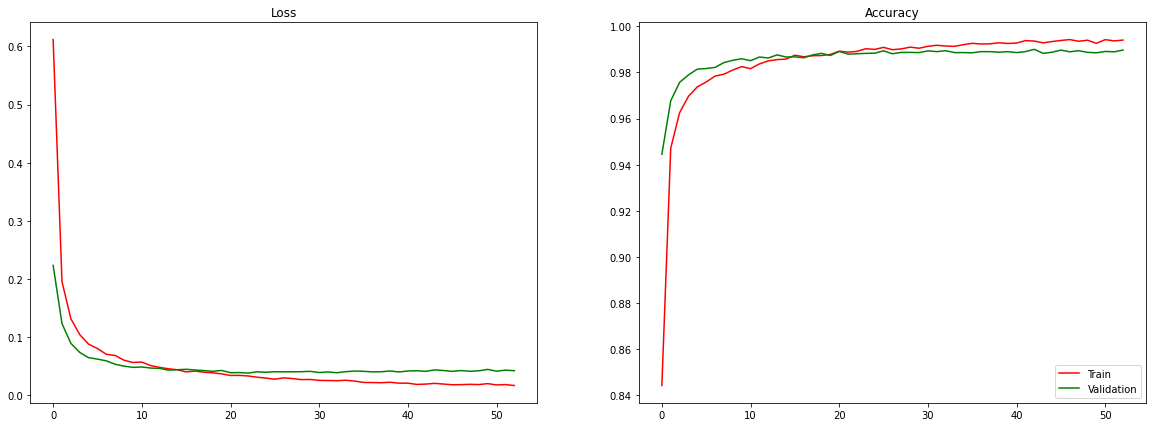

In [0]:
for i in range(num):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_train_exp_1[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_train_exp_1[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_train_exp_1[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_train_exp_1[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(num):
  model_checkpoint_name = 'model_exp_1_' + str(i) + '.h5'
  model_exp_1[i].load_weights(model_checkpoint_name)
  loss, acc = model_exp_1[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0372 - accuracy: 0.9877
Accuracy: 0.9876999855041504
313/313 [==============================] - 1s 2ms/step - loss: 0.0337 - accuracy: 0.9881
Accuracy: 0.988099992275238
313/313 [==============================] - 1s 2ms/step - loss: 0.0361 - accuracy: 0.9895
Accuracy: 0.9894999861717224


#### Conclusion

1 Hidden Layer => 1s 2ms/step - loss: 0.0335 - accuracy: 0.9892

2 Hidden Layer => 1s 2ms/step - loss: 0.0357 - accuracy: 0.9889

3 Hidden Layer => 1s 2ms/step - loss: 0.0321 - accuracy: 0.9894


We decided to use only 1 hidden layer since the accuracy and the lost is almost the same from the other tests (2 and 3 layers) and 1 hidden layer is less complex. Following the Occam's Razor principle, "entities should not be multiplied without necessity.".

### Experiment no. 2, Number of Convolution-subsambling Pairs

+ 1, 2 & 3 Convolution-subsambling Pairs

#### Create NN

In [0]:
num = 3
model_exp_2 = [0] * num
for i in range(num):
  model_name = 'model_exp_2_' + str(i)
  model_exp_2[i] = tf.keras.Sequential(name=model_name)
  model_exp_2[i].add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  
  model_exp_2[i].add(tf.keras.layers.Conv2D(filters=16, kernel_size=4, activation='relu', padding='same', name='convolution1'))
  model_exp_2[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling1'))
  if(i==1):
    model_exp_2[i].add(tf.keras.layers.Conv2D(filters=32, kernel_size=4, activation='relu', padding='same', name='convolution2'))
    model_exp_2[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))
  if(i==2):
    model_exp_2[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution3'))
    model_exp_2[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling3'))


  model_exp_2[i].add(tf.keras.layers.Dropout(0.5, name='dropout'))
  model_exp_2[i].add(tf.keras.layers.Flatten(name='flatten'))

  model_exp_2[i].add(tf.keras.layers.Dense(32, activation='tanh', name='hidden'))
  model_exp_2[i].add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  model_exp_2[i].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_exp_2[i].summary()

Model: "model_exp_2_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution1 (Conv2D)        (None, 28, 28, 16)        272       
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
hidden (Dense)               (None, 32)                100384    
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total params: 100,986
Trainable params: 100,986
Non-trainable params: 0
_______________________________________________

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
model_train_exp_2 = [0] * num
for i in range(num):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  model_checkpoint_name = 'model_exp_2_' + str(i) + '.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

  model_train_exp_2[i] = model_exp_2[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
180/188 [===========================>..] - ETA: 0s - loss: 0.5812 - accuracy: 0.8481
Epoch 00001: val_accuracy improved from -inf to 0.93333, saving model to model_exp_2_0.h5
188/188 [==============================] - 1s 5ms/step - loss: 0.5694 - accuracy: 0.8510 - val_loss: 0.2408 - val_accuracy: 0.9333
Epoch 2/10000
178/188 [===========================>..] - ETA: 0s - loss: 0.2264 - accuracy: 0.9372
Epoch 00002: val_accuracy improved from 0.93333 to 0.96067, saving model to model_exp_2_0.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.2248 - accuracy: 0.9374 - val_loss: 0.1442 - val_accuracy: 0.9607
Epoch 3/10000
181/188 [===========================>..] - ETA: 0s - loss: 0.1603 - accuracy: 0.9550
Epoch 00003: val_accuracy improved from 0.96067 to 0.96892, saving model to model_exp_2_0.h5
188/188 [==============================] - 1s 4ms/step - loss: 0.1598 - accuracy: 0.9549 - val_loss: 0.1112 - val_accuracy: 0.9689
Epoch 4/10000
180/188 [===========

#### Plot the graphs of Loss and Accuracy

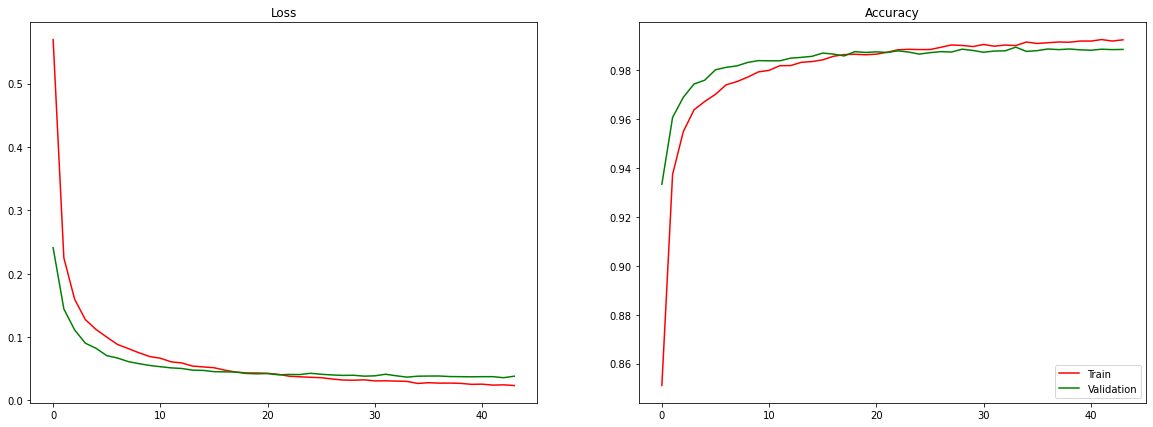

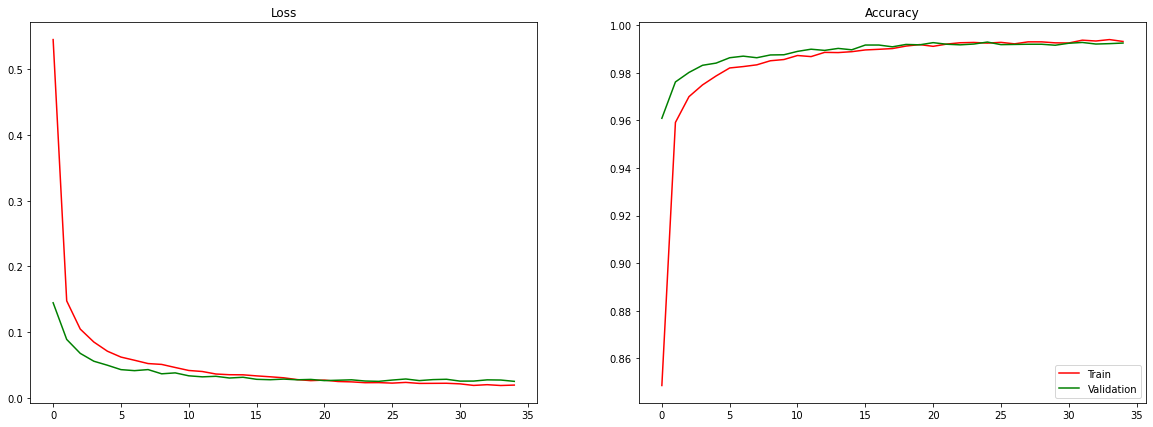

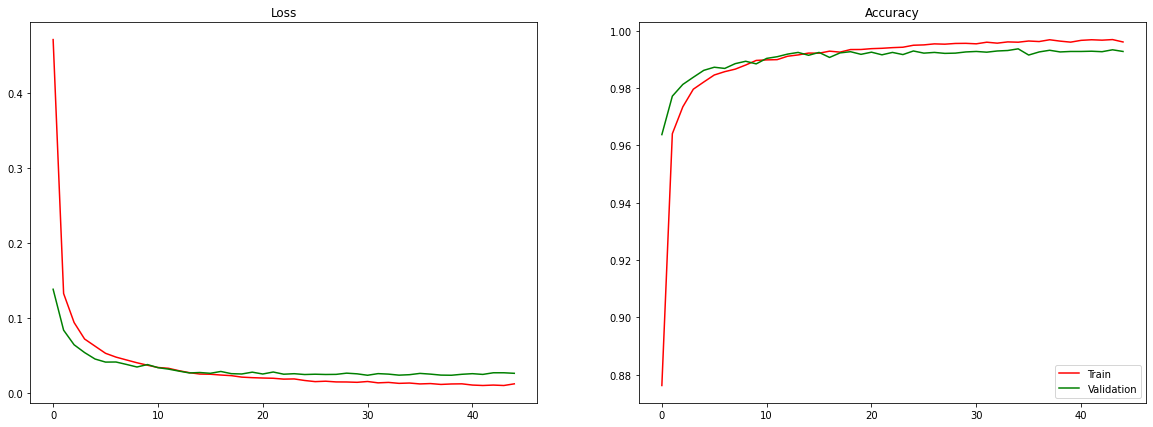

In [0]:
for i in range(num):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_train_exp_2[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_train_exp_2[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_train_exp_2[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_train_exp_2[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(num):
  model_checkpoint_name = 'model_exp_2_' + str(i) + '.h5'
  model_exp_2[i].load_weights(model_checkpoint_name)
  loss, acc = model_exp_2[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0356 - accuracy: 0.9883
Accuracy: 0.9883000254631042
313/313 [==============================] - 1s 2ms/step - loss: 0.0240 - accuracy: 0.9923
Accuracy: 0.9922999739646912
313/313 [==============================] - 1s 2ms/step - loss: 0.0198 - accuracy: 0.9938
Accuracy: 0.9937999844551086


#### Conclusion

1 Convulution-subsambling Pair => 1s 2ms/step - loss: 0.0372 - accuracy: 0.9868

2 Convulution-subsambling Pairs =>  1s 2ms/step - loss: 0.0220 - accuracy: 0.9930

3 Convulution-subsambling Pairs =>  1s 2ms/step - loss: 0.0210 - accuracy: 0.9930


Since 3 convolution-subsambling does not gain any more accuracy and the loss is almost the same, following again the Occam's Razor principle, we decided to use 2.

### Experiment no. 3, Number of filters

+ filters=[16, 24, 32, 48, 64]

#### Create NN

In [0]:
filters_arr = [16, 24, 32, 48, 64]
model_exp_3 = [0] * len(filters_arr)
for i, filter_num in zip(range(len(filters_arr)), filters_arr):
  model_name = 'model_exp_3_' + str(i)
  model_exp_3[i] = tf.keras.Sequential(name=model_name)
  model_exp_3[i].add(tf.keras.layers.Input(mnist_info.features['image'].shape))

  model_exp_3[i].add(tf.keras.layers.Conv2D(filters=filter_num, kernel_size=4, activation='relu', padding='same', name='convolution1'))
  model_exp_3[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling1'))
  model_exp_3[i].add(tf.keras.layers.Conv2D(filters=filter_num*2, kernel_size=4, activation='relu', padding='same', name='convolution2'))
  model_exp_3[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))

  model_exp_3[i].add(tf.keras.layers.Dropout(0.5, name='dropout'))
  model_exp_3[i].add(tf.keras.layers.Flatten(name='flatten'))

  model_exp_3[i].add(tf.keras.layers.Dense(32, activation='tanh', name='hidden'))
  model_exp_3[i].add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  model_exp_3[i].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_exp_3[i].summary()

Model: "model_exp_3_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution1 (Conv2D)        (None, 28, 28, 16)        272       
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 14, 14, 16)        0         
_________________________________________________________________
convolution2 (Conv2D)        (None, 14, 14, 32)        8224      
_________________________________________________________________
pooling2 (MaxPooling2D)      (None, 7, 7, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
hidden (Dense)               (None, 32)              

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
model_train_exp_3 = [0] * len(filters_arr)
for i in range(len(filters_arr)):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  model_checkpoint_name = 'model_exp_3_' + str(i) + '.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

  model_train_exp_3[i] = model_exp_3[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
186/188 [============================>.] - ETA: 0s - loss: 0.5451 - accuracy: 0.8482
Epoch 00001: val_accuracy improved from -inf to 0.96183, saving model to model_exp_3_0.h5
188/188 [==============================] - 1s 6ms/step - loss: 0.5424 - accuracy: 0.8489 - val_loss: 0.1465 - val_accuracy: 0.9618
Epoch 2/10000
188/188 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9584
Epoch 00002: val_accuracy improved from 0.96183 to 0.97500, saving model to model_exp_3_0.h5
188/188 [==============================] - 1s 5ms/step - loss: 0.1501 - accuracy: 0.9584 - val_loss: 0.0897 - val_accuracy: 0.9750
Epoch 3/10000
177/188 [===========================>..] - ETA: 0s - loss: 0.1051 - accuracy: 0.9700
Epoch 00003: val_accuracy improved from 0.97500 to 0.97950, saving model to model_exp_3_0.h5
188/188 [==============================] - 1s 5ms/step - loss: 0.1043 - accuracy: 0.9702 - val_loss: 0.0705 - val_accuracy: 0.9795
Epoch 4/10000
178/188 [===========

#### Plot the graphs of Loss and Accuracy

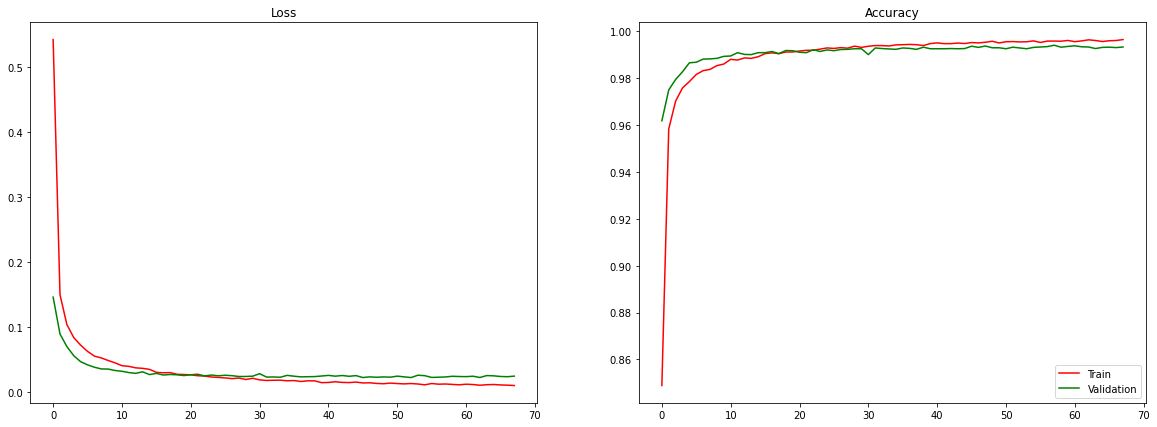

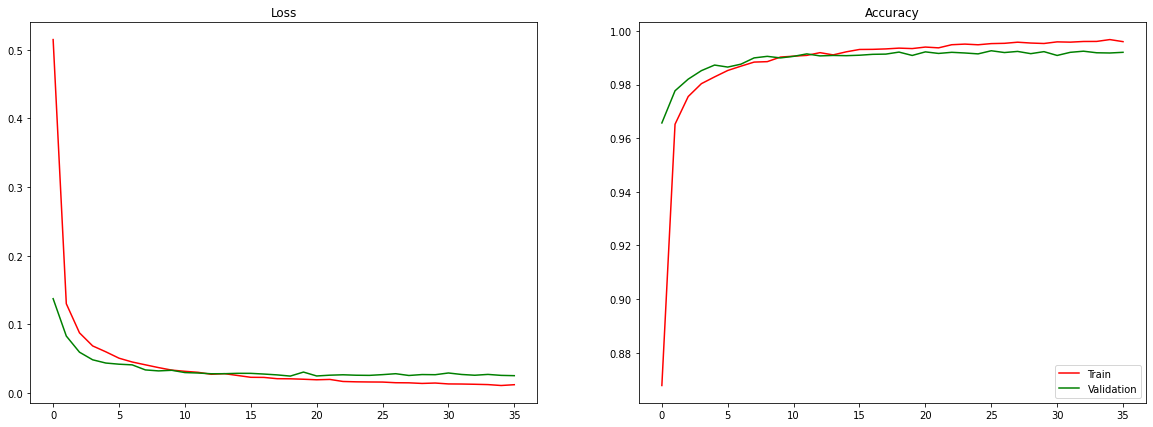

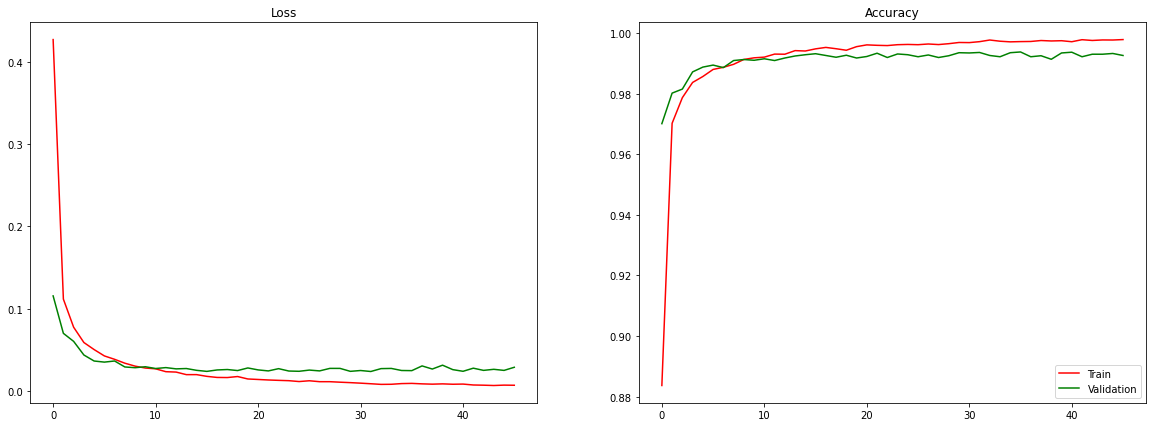

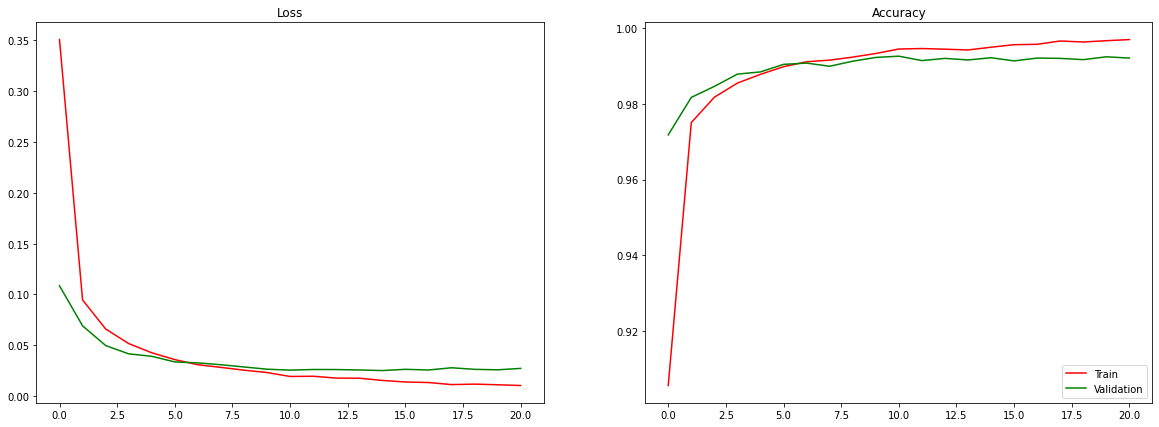

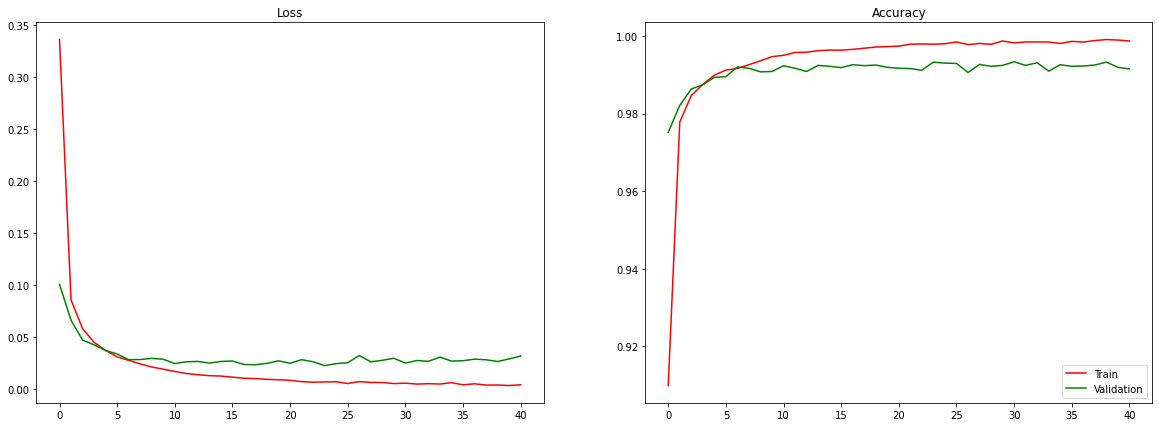

In [0]:
for i in range(len(filters_arr)):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_train_exp_3[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_train_exp_3[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_train_exp_3[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_train_exp_3[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(len(filters_arr)):
  model_checkpoint_name = 'model_exp_3_' + str(i) + '.h5'
  model_exp_3[i].load_weights(model_checkpoint_name)
  loss, acc = model_exp_3[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0241 - accuracy: 0.9926
Accuracy: 0.9926000237464905
313/313 [==============================] - 1s 2ms/step - loss: 0.0233 - accuracy: 0.9921
Accuracy: 0.9921000003814697
313/313 [==============================] - 1s 2ms/step - loss: 0.0231 - accuracy: 0.9928
Accuracy: 0.9927999973297119
313/313 [==============================] - 1s 2ms/step - loss: 0.0248 - accuracy: 0.9917
Accuracy: 0.9916999936103821
313/313 [==============================] - 1s 2ms/step - loss: 0.0234 - accuracy: 0.9936
Accuracy: 0.9936000108718872


#### Conclusion

**1st run**

16 Filters => 1s 2ms/step - loss: 0.0236 - accuracy: 0.9930

24 Filters => 1s 2ms/step - loss: 0.0261 - accuracy: 0.9935

32 Filters => 1s 2ms/step - loss: 0.0221 - accuracy: 0.9935

48 Filters => 1s 2ms/step - loss: 0.0211 - accuracy: 0.9939

64 Filters => 1s 2ms/step - loss: 0.0198 - accuracy: 0.9932


We can conclude that 64 starts to get overfitting and loses accuracy. So we decided to use 48 filters in the next experiments since it does not increase the step time and has the lowest loss and highest accuracy.


### Experiment no. 4, Kernel size

+ kernels=[3, 4, 5, 6]

#### Create NN

In [0]:
kernels_arr = [3, 4, 5, 6]
model_exp_4 = [0] * len(kernels_arr)
for i, kernel_num in zip(range(len(kernels_arr)), kernels_arr):
  model_name = 'model_exp_4_' + str(i)
  model_exp_4[i] = tf.keras.Sequential(name=model_name)
  model_exp_4[i].add(tf.keras.layers.Input(mnist_info.features['image'].shape))

  model_exp_4[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=kernel_num, activation='relu', padding='same', name='convolution1'))
  model_exp_4[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling1'))
  model_exp_4[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=kernel_num, activation='relu', padding='same', name='convolution2'))
  model_exp_4[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))

  model_exp_4[i].add(tf.keras.layers.Dropout(0.5, name='dropout'))
  model_exp_4[i].add(tf.keras.layers.Flatten(name='flatten'))

  model_exp_4[i].add(tf.keras.layers.Dense(32, activation='tanh', name='hidden'))
  model_exp_4[i].add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  model_exp_4[i].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_exp_4[i].summary()

Model: "model_exp_4_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution1 (Conv2D)        (None, 28, 28, 48)        480       
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 14, 14, 48)        0         
_________________________________________________________________
convolution2 (Conv2D)        (None, 14, 14, 48)        20784     
_________________________________________________________________
pooling2 (MaxPooling2D)      (None, 7, 7, 48)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
hidden (Dense)               (None, 32)              

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
model_train_exp_4 = [0] * len(kernels_arr)
for i in range(len(kernels_arr)):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  model_checkpoint_name = 'model_exp_4_' + str(i) + '.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

  model_train_exp_4[i] = model_exp_4[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
188/188 [==============================] - ETA: 0s - loss: 0.4984 - accuracy: 0.8584
Epoch 00001: val_accuracy improved from -inf to 0.96417, saving model to model_exp_4_0.h5
188/188 [==============================] - 1s 8ms/step - loss: 0.4984 - accuracy: 0.8584 - val_loss: 0.1376 - val_accuracy: 0.9642
Epoch 2/10000
186/188 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9633
Epoch 00002: val_accuracy improved from 0.96417 to 0.97858, saving model to model_exp_4_0.h5
188/188 [==============================] - 1s 7ms/step - loss: 0.1338 - accuracy: 0.9634 - val_loss: 0.0804 - val_accuracy: 0.9786
Epoch 3/10000
183/188 [============================>.] - ETA: 0s - loss: 0.0913 - accuracy: 0.9743
Epoch 00003: val_accuracy improved from 0.97858 to 0.98250, saving model to model_exp_4_0.h5
188/188 [==============================] - 1s 7ms/step - loss: 0.0910 - accuracy: 0.9744 - val_loss: 0.0615 - val_accuracy: 0.9825
Epoch 4/10000
179/188 [===========

#### Plot the graphs of Loss and Accuracy

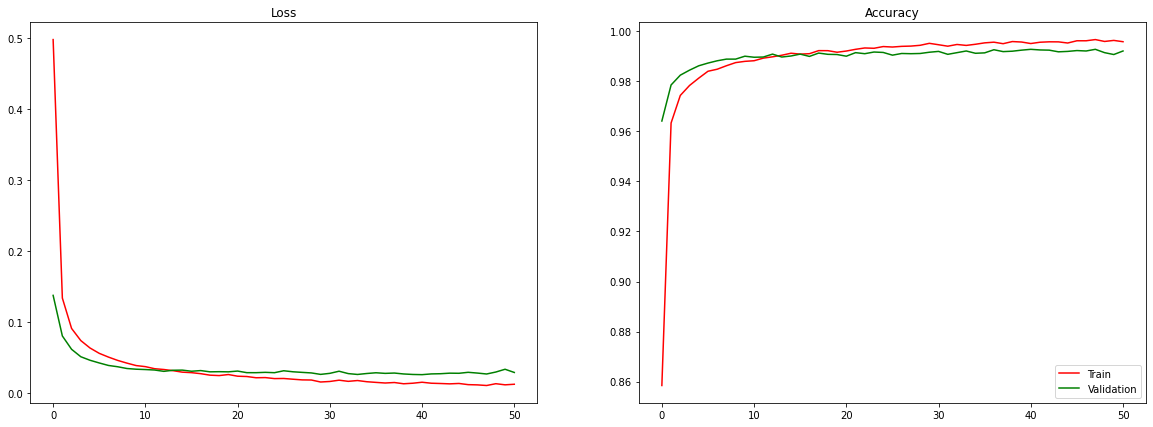

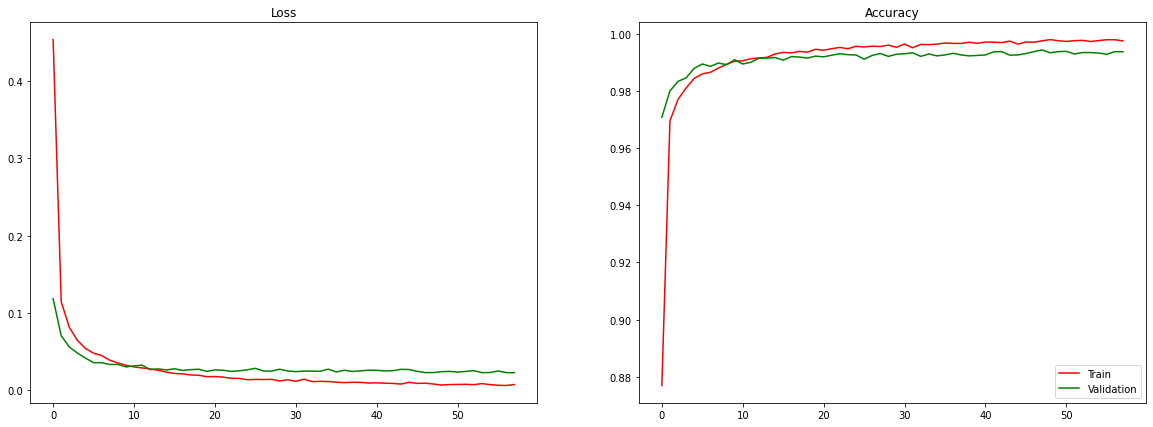

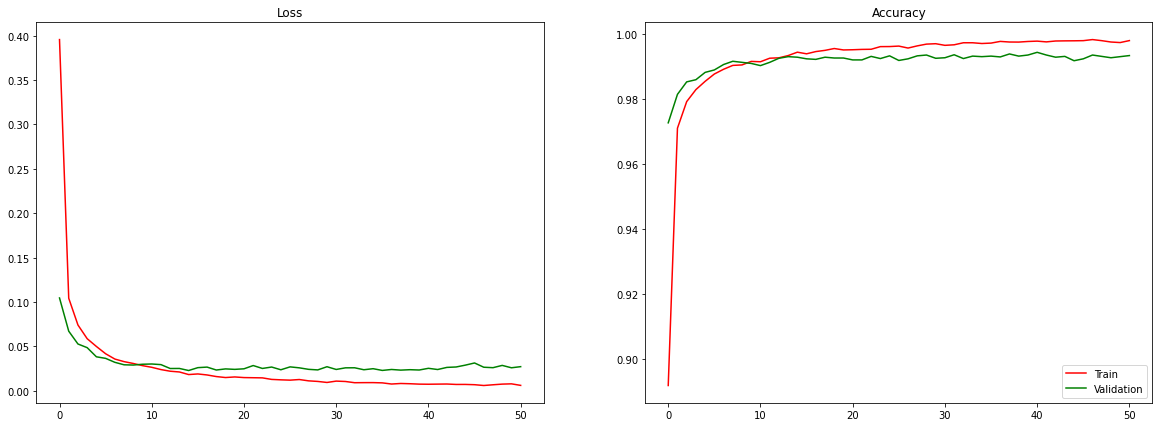

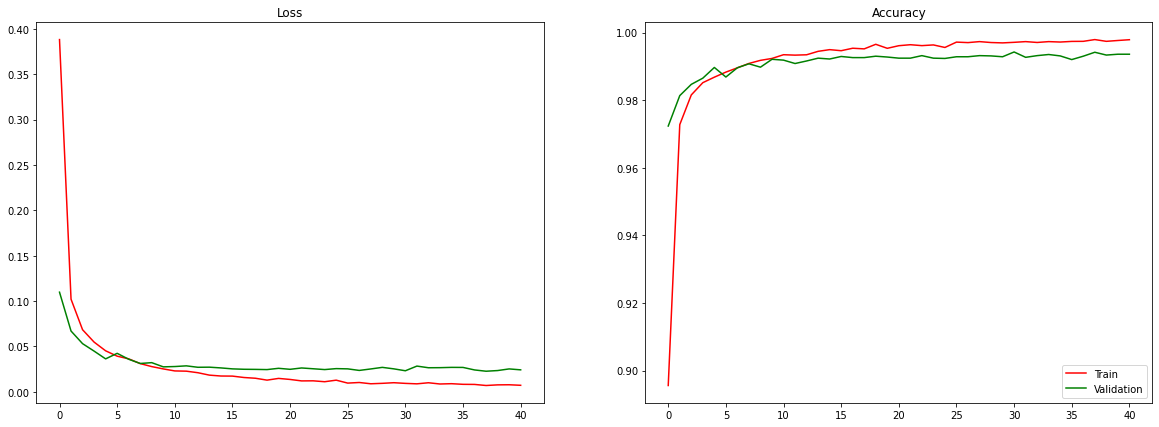

In [0]:
for i in range(len(kernels_arr)):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_train_exp_4[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_train_exp_4[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_train_exp_4[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_train_exp_4[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(len(kernels_arr)):
  model_checkpoint_name = 'model_exp_4_' + str(i) + '.h5'
  model_exp_4[i].load_weights(model_checkpoint_name)
  loss, acc = model_exp_4[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0255 - accuracy: 0.9922
Accuracy: 0.9922000169754028
313/313 [==============================] - 1s 2ms/step - loss: 0.0189 - accuracy: 0.9938
Accuracy: 0.9937999844551086
313/313 [==============================] - 1s 2ms/step - loss: 0.0207 - accuracy: 0.9941
Accuracy: 0.9940999746322632
313/313 [==============================] - 1s 2ms/step - loss: 0.0176 - accuracy: 0.9943
Accuracy: 0.9943000078201294


#### Conclusion

** 1st run **

3 Kernel Size => 1s 2ms/step - loss: 0.0232 - accuracy: 0.9929

4 Kernel Size => 1s 2ms/step - loss: 0.0205 - accuracy: 0.9938

5 Kernel Size => 1s 2ms/step - loss: 0.0197 - accuracy: 0.9935

6 Kernel Size => 1s 2ms/step - loss: 0.0206 - accuracy: 0.9938



Our group concluded that probably with kernel size 4 we get the same performance in accuracy and loss of the 6 and better than 5. In conclusion, we discard 3 and 5 trivially because 4 is better and we discard 6 because we follow the Occam's Razor Principle.

Choose 4.

### Experiment no. 5, Activation of the Convulution

+ Activation=['relu', 'tanh']

#### Create NN

In [0]:
activations_arr = ['relu', 'tanh']
model_exp_5 = [0] * len(activations_arr)
for i, activation_name in zip(range(len(activations_arr)), activations_arr):
  model_name = 'model_exp_5_' + str(i)
  model_exp_5[i] = tf.keras.Sequential(name=model_name)
  model_exp_5[i].add(tf.keras.layers.Input(mnist_info.features['image'].shape))

  model_exp_5[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation=activation_name, padding='same', name='convolution1'))
  model_exp_5[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling1'))
  model_exp_5[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation=activation_name, padding='same', name='convolution2'))
  model_exp_5[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))

  model_exp_5[i].add(tf.keras.layers.Dropout(0.5, name='dropout'))
  model_exp_5[i].add(tf.keras.layers.Flatten(name='flatten'))

  model_exp_5[i].add(tf.keras.layers.Dense(32, activation='tanh', name='hidden'))
  model_exp_5[i].add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  model_exp_5[i].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_exp_5[i].summary()

Model: "model_exp_5_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution1 (Conv2D)        (None, 28, 28, 48)        816       
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 14, 14, 48)        0         
_________________________________________________________________
convolution2 (Conv2D)        (None, 14, 14, 48)        36912     
_________________________________________________________________
pooling2 (MaxPooling2D)      (None, 7, 7, 48)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
hidden (Dense)               (None, 32)              

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
model_train_exp_5 = [0] * len(activations_arr)
for i in range(len(activations_arr)):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  model_checkpoint_name = 'model_exp_5_' + str(i) + '.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

  model_train_exp_5[i] = model_exp_5[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
186/188 [============================>.] - ETA: 0s - loss: 0.4401 - accuracy: 0.8825
Epoch 00001: val_accuracy improved from -inf to 0.96808, saving model to model_exp_5_0.h5
188/188 [==============================] - 2s 9ms/step - loss: 0.4380 - accuracy: 0.8831 - val_loss: 0.1235 - val_accuracy: 0.9681
Epoch 2/10000
182/188 [============================>.] - ETA: 0s - loss: 0.1197 - accuracy: 0.9681
Epoch 00002: val_accuracy improved from 0.96808 to 0.97917, saving model to model_exp_5_0.h5
188/188 [==============================] - 2s 9ms/step - loss: 0.1196 - accuracy: 0.9680 - val_loss: 0.0732 - val_accuracy: 0.9792
Epoch 3/10000
183/188 [============================>.] - ETA: 0s - loss: 0.0832 - accuracy: 0.9763
Epoch 00003: val_accuracy improved from 0.97917 to 0.98242, saving model to model_exp_5_0.h5
188/188 [==============================] - 2s 9ms/step - loss: 0.0828 - accuracy: 0.9764 - val_loss: 0.0567 - val_accuracy: 0.9824
Epoch 4/10000
188/188 [===========

#### Plot the graphs of Loss and Accuracy

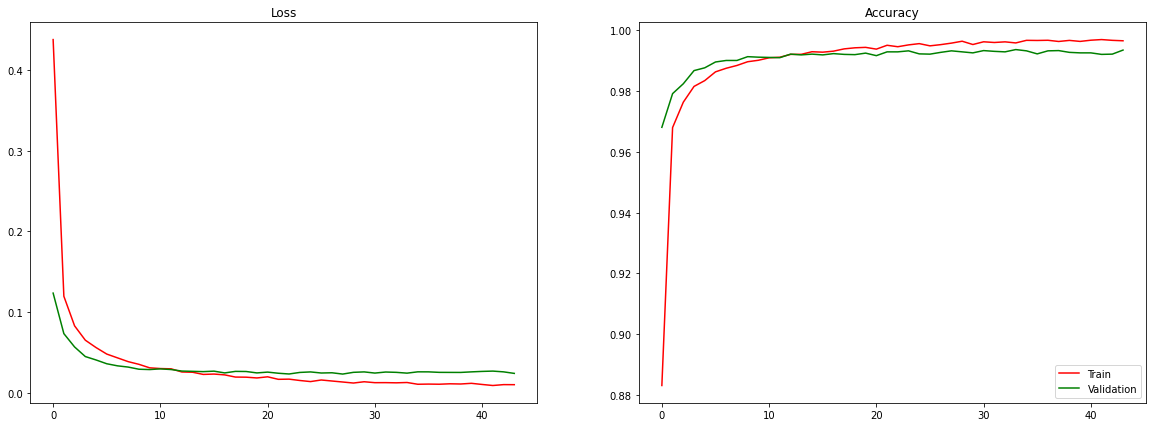

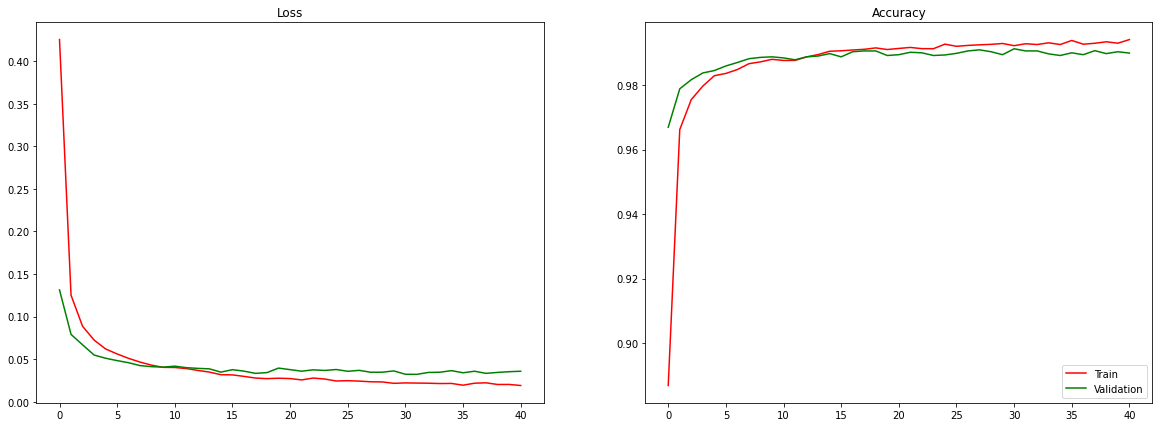

In [0]:
for i in range(len(activations_arr)):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_train_exp_5[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_train_exp_5[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_train_exp_5[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_train_exp_5[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(len(activations_arr)):
  model_checkpoint_name = 'model_exp_5_' + str(i) + '.h5'
  model_exp_5[i].load_weights(model_checkpoint_name)
  loss, acc = model_exp_5[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0225 - accuracy: 0.9937
Accuracy: 0.9937000274658203
313/313 [==============================] - 1s 2ms/step - loss: 0.0296 - accuracy: 0.9905
Accuracy: 0.9904999732971191


#### Conclusion

** 1st run **

relu Activation => 1s 2ms/step - loss: 0.0221 - accuracy: 0.9931

tanh Activation => 1s 2ms/step - loss: 0.0250 - accuracy: 0.9920



Until now, we were using relu activation and after testing tanh, we kept using relu since it has more accuracy and less loss.

Choose relu.

### Experiment no. 6, Hidden layer size.

+ hiddens=[32, 64, 128, 256]

#### Create NN

In [0]:
hiddens_arr = [32, 64, 128, 256]
model_exp_6 = [0] * len(hiddens_arr)
for i, hidden_num in zip(range(len(hiddens_arr)), hiddens_arr):
  model_name = 'model_exp_6_' + str(i)
  model_exp_6[i] = tf.keras.Sequential(name=model_name)
  model_exp_6[i].add(tf.keras.layers.Input(mnist_info.features['image'].shape))

  model_exp_6[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution1'))
  model_exp_6[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling1'))
  model_exp_6[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution2'))
  model_exp_6[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))

  model_exp_6[i].add(tf.keras.layers.Dropout(0.5, name='dropout'))
  model_exp_6[i].add(tf.keras.layers.Flatten(name='flatten'))

  model_exp_6[i].add(tf.keras.layers.Dense(hidden_num, activation='tanh', name='hidden'))
  model_exp_6[i].add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  model_exp_6[i].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_exp_6[i].summary()

Model: "model_exp_6_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convolution1 (Conv2D)        (None, 28, 28, 48)        816       
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 14, 14, 48)        0         
_________________________________________________________________
convolution2 (Conv2D)        (None, 14, 14, 48)        36912     
_________________________________________________________________
pooling2 (MaxPooling2D)      (None, 7, 7, 48)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 48)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
hidden (Dense)               (None, 32)              

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
model_train_exp_6 = [0] * len(hiddens_arr)
for i in range(len(hiddens_arr)):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  model_checkpoint_name = 'model_exp_6_' + str(i) + '.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

  model_train_exp_6[i] = model_exp_6[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

Epoch 1/10000
185/188 [============================>.] - ETA: 0s - loss: 0.4286 - accuracy: 0.8827
Epoch 00001: val_accuracy improved from -inf to 0.96775, saving model to model_exp_6_0.h5
188/188 [==============================] - 2s 10ms/step - loss: 0.4243 - accuracy: 0.8839 - val_loss: 0.1219 - val_accuracy: 0.9678
Epoch 2/10000
182/188 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9683
Epoch 00002: val_accuracy improved from 0.96775 to 0.97958, saving model to model_exp_6_0.h5
188/188 [==============================] - 2s 9ms/step - loss: 0.1189 - accuracy: 0.9682 - val_loss: 0.0730 - val_accuracy: 0.9796
Epoch 3/10000
188/188 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.9771
Epoch 00003: val_accuracy improved from 0.97958 to 0.98117, saving model to model_exp_6_0.h5
188/188 [==============================] - 2s 9ms/step - loss: 0.0823 - accuracy: 0.9771 - val_loss: 0.0650 - val_accuracy: 0.9812
Epoch 4/10000
187/188 [==========

#### Plot the graphs of Loss and Accuracy

In [0]:
for i in range(len(hiddens_arr)):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_train_exp_6[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_train_exp_6[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_train_exp_6[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_train_exp_6[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(len(hiddens_arr)):
  model_checkpoint_name = 'model_exp_6_' + str(i) + '.h5'
  model_exp_6[i].load_weights(model_checkpoint_name)
  loss, acc = model_exp_6[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

#### Conclusion

**1st run**

32 Neurons => 1s 2ms/step - loss: 0.0201 - accuracy: 0.9935

64 Neurons => 1s 2ms/step - loss: 0.0211 - accuracy: 0.9932

128 Neurons => 1s 2ms/step - loss: 0.0205 - accuracy: 0.9935

256 Neurons => 1s 2ms/step - loss: 0.0229 - accuracy: 0.9927



The less complex and with better loss and accuracy is the 32 as we've been using. This way we choose 32 neurons


32 neurons.



### Experiment no. 7, Activation of the Hidden layer.

+ Activation=['relu', 'tanh']

#### Create NN

In [0]:
activations_arr = ['relu', 'tanh']
model_exp_7 = [0] * len(activations_arr)
for i, activation_name in zip(range(len(activations_arr)), activations_arr):
  model_name = 'model_exp_7_' + str(i)
  model_exp_7[i] = tf.keras.Sequential(name=model_name)
  model_exp_7[i].add(tf.keras.layers.Input(mnist_info.features['image'].shape))

  model_exp_7[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution1'))
  model_exp_7[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling1'))
  model_exp_7[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution2'))
  model_exp_7[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))

  model_exp_7[i].add(tf.keras.layers.Dropout(0.5, name='dropout'))
  model_exp_7[i].add(tf.keras.layers.Flatten(name='flatten'))

  model_exp_7[i].add(tf.keras.layers.Dense(32, activation=activation_name, name='hidden'))
  model_exp_7[i].add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  model_exp_7[i].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_exp_7[i].summary()

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
model_train_exp_7 = [0] * len(activations_arr)
for i in range(len(activations_arr)):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  model_checkpoint_name = 'model_exp_7_' + str(i) + '.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

  model_train_exp_7[i] = model_exp_7[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

#### Plot the graphs of Loss and Accuracy

In [0]:
for i in range(len(activations_arr)):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_train_exp_7[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_train_exp_7[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_train_exp_7[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_train_exp_7[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(len(activations_arr)):
  model_checkpoint_name = 'model_exp_7_' + str(i) + '.h5'
  model_exp_7[i].load_weights(model_checkpoint_name)
  loss, acc = model_exp_7[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

#### Conclusion

**1st run**

relu Activation => 1s 2ms/step - loss: 0.0211 - accuracy: 0.9929

tanh Activation => 1s 2ms/step - loss: 0.0219 - accuracy: 0.9935




They both are very similar, since relu's has better loss but worst accuracy and tanh has worst loss but better accuracy. For this, our group decided to keep with tanh, since maybe the decision of previous experiments leaded.


tanh Activation.



### Experiment no. 8, Dropout

+ dropouts = [0.25, 0.5, 0.75]

#### Create NN

In [0]:
dropouts = [0.25, 0.5, 0.75]
model_exp_8 = [0] * len(dropouts)
for i, num_dropout in zip(range(len(dropouts)), dropouts):
  model_name = 'model_exp_8_' + str(i)
  model_exp_8[i] = tf.keras.Sequential(name=model_name)
  model_exp_8[i].add(tf.keras.layers.Input(mnist_info.features['image'].shape))
  model_exp_8[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution1'))
  model_exp_8[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling1'))
  model_exp_8[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution2'))
  model_exp_8[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))

  model_exp_8[i].add(tf.keras.layers.Dropout(num_dropout, name='dropout'))
  model_exp_8[i].add(tf.keras.layers.Flatten(name='flatten'))

  model_exp_8[i].add(tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='hidden'))
  model_exp_8[i].add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  model_exp_8[i].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_exp_8[i].summary()

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
model_train_exp_8 = [0] * len(dropouts)
for i in range(len(dropouts)):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  model_checkpoint_name = 'model_exp_8_' + str(i) + '.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

  model_train_exp_8[i] = model_exp_8[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

#### Plot the graphs of Loss and Accuracy

In [0]:
for i in range(len(dropouts)):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_train_exp_8[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_train_exp_8[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_train_exp_8[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_train_exp_8[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(len(dropouts)):
  model_checkpoint_name = 'model_exp_8_' + str(i) + '.h5'
  model_exp_8[i].load_weights(model_checkpoint_name)
  loss, acc = model_exp_8[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

#### Conclusion

**1st run:**

Dropout = 0.25 => 1s 2ms/step - loss: 0.0649 - accuracy: 0.9908

Dropout = 0.5 => 1s 2ms/step - loss: 0.0652 - accuracy: 0.9928

Dropout = 0.75 => 1s 2ms/step - loss: 0.0807 - accuracy: 0.9929




Different dropouts don't affect the performance since every one tested concluded in 1s 2ms/step, we move foward using the one that gives us the best accuracy with fewer loss. In this case, the 0.5 dropout percentage has much less loss than 0.75 and almost the same accuracy. Also 0.5 has a bit higher accuracy than 0.25 and that's why picked 0.5.

**We picked Dropout=0.5**

### Experiment no. 9, Optimizer

+ Optimizer=['adam', 'sgd']

#### Create NN

In [0]:
optimizers_arr = ['adam', 'sgd']
model_exp_9 = [0] * len(optimizers_arr)
for i, optimizer_name in zip(range(len(optimizers_arr)), optimizers_arr):
  model_name = 'model_exp_9_' + str(i)
  model_exp_9[i] = tf.keras.Sequential(name=model_name)
  model_exp_9[i].add(tf.keras.layers.Input(mnist_info.features['image'].shape))

  model_exp_9[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution1'))
  model_exp_9[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling1'))
  model_exp_9[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution2'))
  model_exp_9[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))

  model_exp_9[i].add(tf.keras.layers.Dropout(0.5, name='dropout'))
  model_exp_9[i].add(tf.keras.layers.Flatten(name='flatten'))

  model_exp_9[i].add(tf.keras.layers.Dense(32, activation='tanh', name='hidden'))
  model_exp_9[i].add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  model_exp_9[i].compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_name, metrics=['accuracy'])
  model_exp_9[i].summary()

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
model_train_exp_9 = [0] * len(optimizers_arr)
for i in range(len(optimizers_arr)):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  model_checkpoint_name = 'model_exp_9_' + str(i) + '.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

  model_train_exp_9[i] = model_exp_9[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

#### Plot the graphs of Loss and Accuracy

In [0]:
for i in range(len(optimizers_arr)):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_train_exp_9[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_train_exp_9[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_train_exp_9[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_train_exp_9[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(len(optimizers_arr)):
  model_checkpoint_name = 'model_exp_9_' + str(i) + '.h5'
  model_exp_9[i].load_weights(model_checkpoint_name)
  loss, acc = model_exp_9[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

#### Conclusion

**1st run**

adam Optimizer => 1s 2ms/step - loss: 0.0203 - accuracy: 0.9938

sgd Optimizer => 1s 2ms/step - loss: 0.0347 - accuracy: 0.9897


We can trivially see that adam is much better in terms of loss and accuracy.

We choose adam.









### Experiment no. 10, Regularization

+ Regularization=[L1, L1_L2, L2]

#### Create NN

In [0]:
num = 3
model_exp_10 = [0] * num
for i in range(num):
  model_name = 'model_exp_10_' + str(i)
  model_exp_10[i] = tf.keras.Sequential(name=model_name)
  model_exp_10[i].add(tf.keras.layers.Input(mnist_info.features['image'].shape))

  model_exp_10[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution1'))
  model_exp_10[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling1'))
  model_exp_10[i].add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution2'))
  model_exp_10[i].add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))

  model_exp_10[i].add(tf.keras.layers.Dropout(0.5, name='dropout'))
  model_exp_10[i].add(tf.keras.layers.Flatten(name='flatten'))

  if(i==0):
    model_exp_10[i].add(tf.keras.layers.Dense(32, activation=activation_name, kernel_regularizer=tf.keras.regularizers.l1(0.01), name='hidden'))
  if(i==1):
    model_exp_10[i].add(tf.keras.layers.Dense(32, activation=activation_name, kernel_regularizer=tf.keras.regularizers.l1_l2(0.01), name='hidden'))
  if(i==2):
    model_exp_10[i].add(tf.keras.layers.Dense(32, activation=activation_name, kernel_regularizer=tf.keras.regularizers.l2(0.01), name='hidden'))
  
  model_exp_10[i].add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
  model_exp_10[i].compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_exp_10[i].summary()

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
model_train_exp_10 = [0] * num
for i in range(num):
  earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
  model_checkpoint_name = 'model_exp_10_' + str(i) + '.h5'
  checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

  model_train_exp_10[i] = model_exp_10[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

#### Plot the graphs of Loss and Accuracy

In [0]:
for i in range(num):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_train_exp_10[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_train_exp_10[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_train_exp_10[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_train_exp_10[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(num):
  model_checkpoint_name = 'model_exp_10_' + str(i) + '.h5'
  model_exp_10[i].load_weights(model_checkpoint_name)
  loss, acc = model_exp_10[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

#### Conclusion

**1st run**

relu Activation => 1s 2ms/step - loss: 0.0211 - accuracy: 0.9929

tanh Activation => 1s 2ms/step - loss: 0.0219 - accuracy: 0.9935




They both are very similar, since relu's has better loss but worst accuracy and tanh has worst loss but better accuracy. For this, our group decided to keep with tanh, since maybe the decision of previous experiments leaded.


tanh Activation.



## Feed-Forward Networks



#### Multi-Layer Model

To create a network with hidden layers, we simply add additional [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layers before the output layer:

In [0]:
multi_layer_model = tf.keras.Sequential(name='multi_layer')
multi_layer_model.add(tf.keras.layers.Input(iris_info.features['features'].shape))
multi_layer_model.add(tf.keras.layers.Dense(256, activation='tanh', name='hidden'))
multi_layer_model.add(tf.keras.layers.Dense(iris_info.features['label'].num_classes, activation='softmax', name='output'))

multi_layer_model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
multi_layer_model.summary()

Let's also use callbacks for stopping the training phase:



In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('multi_layer_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

Now we can train the model:

In [0]:
multi_layer_train = multi_layer_model.fit(iris_x, iris_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=32)

And plot the evolution:

In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(multi_layer_train.history['loss'], '-r', label='Train')
loss_ax.plot(multi_layer_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(multi_layer_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(multi_layer_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

##### Regularization

When adding layers to the network, we can also include regularization in those layers using three different parameters: *kernel_regularizer*, *bias_regularizer*, and *activity_regularizer*. The first applies regularization to the weights of the layer, the second to its bias, and the last to its output. [Keras](https://www.tensorflow.org/api_docs/python/tf/keras) also has implementations of multiple [regularizers](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers). As an example, lets create a network with the same architecture as the previous, but with [L2](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2) regularization to the weights of the hidden layer:

In [0]:
multi_layer_reg_model = tf.keras.Sequential(name='multi_layer_regularization')
multi_layer_reg_model.add(tf.keras.layers.Input(iris_info.features['features'].shape))
multi_layer_reg_model.add(tf.keras.layers.Dense(256, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01), name='hidden'))
multi_layer_reg_model.add(tf.keras.layers.Dense(iris_info.features['label'].num_classes, activation='softmax', name='output'))

multi_layer_reg_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
multi_layer_reg_model.summary()

Now, let's train it on the [Iris](https://archive.ics.uci.edu/ml/datasets/iris) dataset:

In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('multi_layer_reg_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True)

multi_layer_reg_train = multi_layer_reg_model.fit(iris_x, iris_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=32)

We can see that the model converges faster. Also, by plotting the evolution, we can see that there are fewer oscillations:

In [0]:
fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

loss_ax.set_title('Loss')
loss_ax.plot(multi_layer_reg_train.history['loss'], '-r', label='Train')
loss_ax.plot(multi_layer_reg_train.history['val_loss'], '-g', label='Validation')

acc_ax.set_title('Accuracy')
acc_ax.plot(multi_layer_reg_train.history['accuracy'], '-r', label='Train')
acc_ax.plot(multi_layer_reg_train.history['val_accuracy'], '-g', label='Validation')

plt.legend(loc=4)
plt.show()

### Comparison between FNN and CNN

#### Create NN

In [0]:
#Convulutional Neural Network

model_best_cnn = tf.keras.Sequential(name='model_best_cnn')
model_best_cnn.add(tf.keras.layers.Input(mnist_info.features['image'].shape))

model_best_cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution1'))
model_best_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling1'))
model_best_cnn.add(tf.keras.layers.Conv2D(filters=48, kernel_size=4, activation='relu', padding='same', name='convolution2'))
model_best_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, name='pooling2'))

model_best_cnn.add(tf.keras.layers.Dropout(0.5, name='dropout'))
model_best_cnn.add(tf.keras.layers.Flatten(name='flatten'))

model_best_cnn.add(tf.keras.layers.Dense(32, activation='tanh', name='hidden'))
model_best_cnn.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
model_best_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_best_cnn.summary()


#Feed-Forward Neural Network

model_fnn = tf.keras.Sequential(name='model_fnn')
model_fnn.add(tf.keras.layers.Input(mnist_info.features['image'].shape))

model_fnn.add(tf.keras.layers.Dropout(0.5, name='dropout'))
model_fnn.add(tf.keras.layers.Flatten(name='flatten'))

model_fnn.add(tf.keras.layers.Dense(32, activation='tanh', name='hidden'))
model_fnn.add(tf.keras.layers.Dense(mnist_info.features['label'].num_classes, activation='softmax', name='output'))
model_fnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_fnn.summary()

#### Train NN

 - Create earlystop
 - Create checkpoint
 - Train

In [0]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

model_fnn_train_exp_1[i] = model_fnn_exp_1[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)


# Feed-Forward Neural Network

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_name, monitor='val_accuracy', verbose=1, save_best_only=True)

model_fnn_train_exp_1[i] = model_fnn_exp_1[i].fit(mnist_train_x, mnist_train_y, validation_split=0.2, callbacks=[earlystop,checkpoint], epochs=10000, batch_size=256)

#### Plot the graphs of Loss and Accuracy

In [0]:
for i in range(num):
  fig, (loss_ax, acc_ax) = plt.subplots(1, 2, figsize=(20,7))

  loss_ax.set_title('Loss')
  loss_ax.plot(model_fnn_train_exp_1[i].history['loss'], '-r', label='Train')
  loss_ax.plot(model_fnn_train_exp_1[i].history['val_loss'], '-g', label='Validation')

  acc_ax.set_title('Accuracy')
  acc_ax.plot(model_fnn_train_exp_1[i].history['accuracy'], '-r', label='Train')
  acc_ax.plot(model_fnn_train_exp_1[i].history['val_accuracy'], '-g', label='Validation')

  plt.legend(loc=4)
  plt.show()

#### Accuracy Check

In [0]:
for i in range(num):
  model_checkpoint_name = 'model_fnn_exp_1_' + str(i) + '.h5'
  model_fnn_exp_1[i].load_weights(model_checkpoint_name)
  loss, acc = model_fnn_exp_1[i].evaluate(mnist_test_x, mnist_test_y)
  print('Accuracy: {}'.format(acc))

**1st run**

1 Hidden Layer => 1s 2ms/step - loss: 0.1468 - accuracy: 0.9578

2 Hidden Layer =>  1s 2ms/step - loss: 0.1287 - accuracy: 0.9613

3 Hidden Layer =>  1s 2ms/step - loss: 0.1310 - accuracy: 0.9618


